In [1]:
import pickle
import gym
import time
import numpy as np 
import random
import torch
from run_test import *
%matplotlib inline
import matplotlib.pylab as plt


Logging to /tmp/openai-2018-11-29-11-49-16-838770


set up the code for running trajectories with pong


In [2]:
#try it just for two trajectories

env_id = "SpaceInvadersNoFrameskip-v4"
env_type = "atari"
env_name = "spaceinvaders"

#env id, env type, num envs, and seed
env = make_vec_env(env_id, 'atari', 1, 0,
                   wrapper_kwargs={
                       'clip_rewards':False,
                       'episode_life':False,
                   })


env = VecFrameStack(env, 4)
agent = PPO2Agent(env, env_type)
#agent = RandomAgent(env.action_space)

/home/dsbrown/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:

def normalize_state(obs):
    obs_highs = env.observation_space.high
    obs_lows = env.observation_space.low
    #print(obs_highs)
    #print(obs_lows)
    #return  2.0 * (obs - obs_lows) / (obs_highs - obs_lows) - 1.0
    return obs / 255.0


In [4]:
checkpoint_min = 100
checkpoint_max = 500
checkpoint_step = 100
checkpoints = []
for i in range(checkpoint_min, checkpoint_max + checkpoint_step, checkpoint_step):
    if i < 1000:
        checkpoints.append('00' + str(i))
    elif i < 10000:
        checkpoints.append('0' + str(i))
print(checkpoints)

['00100', '00200', '00300', '00400', '00500']


In [5]:
demonstrations = []
learning_returns = []
for checkpoint in checkpoints:
    
    model_path = "./models/" + env_name + "/checkpoints/" + checkpoint
    
    agent.load(model_path)
    episode_count = 6
    for i in range(episode_count):
        done = False
        traj = []
        r = 0
        
        ob = env.reset()
        #traj.append(ob)
        #print(ob.shape)
        steps = 0
        acc_reward = 0
        while True:
            action = agent.act(ob, r, done)
            ob, r, done, _ = env.step(action)
            #print(ob.shape)
            traj.append(normalize_state(ob))
            steps += 1
            acc_reward += r[0]
            if done:
                print("checkpoint: {}, steps: {}, return: {}".format(checkpoint, steps,acc_reward))
                break
        print("traj length", len(traj))
        print("demo length", len(demonstrations))
        if acc_reward not in learning_returns:
            demonstrations.append(traj)
            learning_returns.append(acc_reward)
    


env.close()


    
    
print(learning_returns)

checkpoint: 00100, steps: 524, return: 175.0
traj length 524
demo length 0
checkpoint: 00100, steps: 545, return: 125.0
traj length 545
demo length 1
checkpoint: 00100, steps: 361, return: 120.0
traj length 361
demo length 2
checkpoint: 00100, steps: 340, return: 135.0
traj length 340
demo length 3
checkpoint: 00100, steps: 486, return: 220.0
traj length 486
demo length 4
checkpoint: 00100, steps: 459, return: 175.0
traj length 459
demo length 5
checkpoint: 00200, steps: 697, return: 370.0
traj length 697
demo length 5
checkpoint: 00200, steps: 507, return: 185.0
traj length 507
demo length 6
checkpoint: 00200, steps: 1039, return: 495.0
traj length 1039
demo length 7
checkpoint: 00200, steps: 952, return: 545.0
traj length 952
demo length 8
checkpoint: 00200, steps: 585, return: 200.0
traj length 585
demo length 9
checkpoint: 00200, steps: 939, return: 550.0
traj length 939
demo length 10
checkpoint: 00300, steps: 686, return: 535.0
traj length 686
demo length 11
checkpoint: 00300, st

Let's plot the returns to see if they are roughly monotonically increasing.

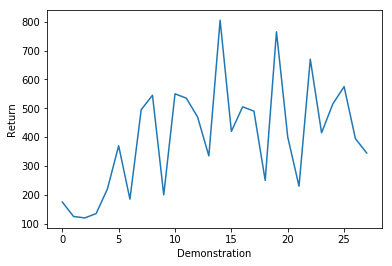

In [6]:
plt.plot(learning_returns)
plt.xlabel("Demonstration")
plt.ylabel("Return")
plt.savefig("breakoutLearningPPO.png")
plt.show()

28
28
[175.0, 125.0, 120.0, 135.0, 220.0, 370.0, 185.0, 495.0, 545.0, 200.0, 550.0, 535.0, 470.0, 335.0, 805.0, 420.0, 505.0, 490.0, 250.0, 765.0, 400.0, 230.0, 670.0, 415.0, 515.0, 575.0, 395.0, 345.0]
[175.0, 125.0, 120.0, 135.0, 220.0, 370.0, 185.0, 495.0, 545.0, 200.0, 550.0, 535.0, 470.0, 335.0, 805.0, 420.0, 505.0, 490.0, 250.0, 765.0, 400.0, 230.0, 670.0, 415.0, 515.0, 575.0, 395.0, 345.0]


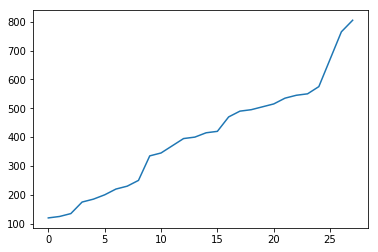

In [7]:
print(len(learning_returns))
print(len(demonstrations))
print([a[0] for a in zip(learning_returns, demonstrations)])
#cheat and sort them to see if it helps learning
sorted_demos = [x for _, x in sorted(zip(learning_returns,demonstrations), key=lambda pair: pair[0])]

sorted_returns = sorted(learning_returns)
print(learning_returns)
plt.plot(sorted_returns)

Split the data into train and validation sets

In [8]:
train_demos = []
train_returns = []
valid_demos = []
valid_returns = []

for i,d in enumerate(sorted_demos):
    print(i)
    if i % 5 is not 4:
        train_demos.append(d)
        train_returns.append(sorted_returns[i])
    else:
        valid_demos.append(d)
        valid_returns.append(sorted_returns[i])

print(train_returns)
print(valid_returns)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
[120.0, 125.0, 135.0, 175.0, 200.0, 220.0, 230.0, 250.0, 345.0, 370.0, 395.0, 400.0, 420.0, 470.0, 490.0, 495.0, 515.0, 535.0, 545.0, 550.0, 670.0, 765.0, 805.0]
[185.0, 335.0, 415.0, 505.0, 575.0]


In [23]:
import numpy as np
demoer_returns = train_returns
print(len(train_returns))
[np.max(demoer_returns), np.min(demoer_returns), np.mean(demoer_returns)]

23


[805.0, 120.0, 401.0869565217391]

Now I want to build a neural network to predict the reward the learner is trying to optimize. The inputs are 84x84x4 grayscale images. I'm going to try and use the NIPS architecture from DeepMind.

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 16, 7, stride=3)
        self.conv2 = nn.Conv2d(16, 16, 5, stride=2)
        self.conv3 = nn.Conv2d(16, 16, 3, stride=1)
        self.conv4 = nn.Conv2d(16, 16, 3, stride=1)
        self.fc1 = nn.Linear(1936, 64)
        self.fc2 = nn.Linear(64, 1)
        
        
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            x = x.permute(0,3,1,2) #get into NCHW format
            #compute forward pass of reward network
            x = F.leaky_relu(self.conv1(x))
            x = F.leaky_relu(self.conv2(x))
            x = x.view(-1, 1936)
            x = F.leaky_relu(self.fc1(x))
            r = torch.sigmoid(self.fc2(x)) #clip reward?
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    
class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 8, 8, stride=4)
        self.conv2 = nn.Conv2d(8, 16, 4, stride=2)
        self.fc1 = nn.Linear(9*9*16, 1)
        #self.fc2 = nn.Linear(256, 1)
        
        
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            x = x.permute(0,3,1,2)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(-1, 9*9*16)
            r = torch.tanh(self.fc1(x))
            
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    


Now we train the network. I'm just going to do it one by one for now. Could adapt it for minibatches to get better gradients

In [12]:
def learn_reward(reward_network, optimizer, trajectories, num_iter):
    loss_criterion = nn.CrossEntropyLoss()
    #print(training_data[0])
    cum_loss = 0.0
    for epoch in range(num_iter):
        #pick two random trajectories, traj_i and traj_j and give classification label to later one
        j = np.random.randint(len(trajectories)) 
        i = np.random.randint(len(trajectories))
        while(i == j):
            i = np.random.randint(len(trajectories))
        #print(i,j)
        #traj_i = np.array([[d[0]] for d in trajectories[i]])
        #traj_j = np.array([[d[0]] for d in trajectories[j]])
        traj_i = np.array(trajectories[i])
        traj_j = np.array(trajectories[j])
        if i > j:
            labels = np.array([[0]])
        else:
            labels = np.array([[1]])
            
        traj_i = torch.from_numpy(traj_i).float().to(device)
        traj_j = torch.from_numpy(traj_j).float().to(device)
        labels = torch.from_numpy(labels).to(device)
        
        #zero out gradient
        optimizer.zero_grad()

        #forward + backward + optimize
        outputs = reward_network.forward(traj_i, traj_j).unsqueeze(0)
        #print(outputs)
        #print(labels)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print stats to see if learning
        item_loss = loss.item()
        cum_loss += item_loss
        if epoch % 50 == 49:
            #with torch.no_grad():
            #    print(torch.cat([reward_network.cum_return(torch.from_numpy(np.array(traj)).float()) for traj in trajectories]))
            print(epoch, cum_loss / 50)
            cum_loss = 0.0
    print("finished training")



        
    

Now we create a reward network and optimize it using the training data.

Trying shorter snippets of the demos, should use a sliding window over all demos to get lots of training data, but just  trying the last H frames for now, where H is length of first (the shortest) demo 

In [19]:
H = len(train_demos[0])
print(H)
demos_fh = [d[len(d)-40:-1] for d in train_demos]
print(len(demos_fh))
reward_fh = Net()
reward_fh.to(device)
import torch.optim as optim
optimizer = optim.Adam(reward_fh.parameters(),  lr = 0.0001, weight_decay=0.01)
learn_reward(reward_fh, optimizer, demos_fh, 1000)

361
23
49 0.6435416793823242
99 0.3440068054199219
149 0.31824262619018556
199 0.2602596855163574
249 0.27596298217773435
299 0.2296730613708496
349 0.19500808715820311
399 0.18329935073852538
449 0.19171627044677733
499 0.17884315490722658
549 0.0899492073059082
599 0.19490386962890624
649 0.08253499984741211
699 0.14268266677856445
749 0.11514659881591797
799 0.07492441177368164
849 0.026086273193359374
899 0.09547266006469726
949 0.032948274612426755
999 0.04669269561767578
finished training


See what predicted returns look like compared to actual

In [20]:
with torch.no_grad():
    pred_returns = [reward_fh.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in demos_fh]
for i, p in enumerate(pred_returns):
    print(i,p,train_returns[i])

0 7.157937049865723 120.0
1 9.161670684814453 125.0
2 10.819911003112793 135.0
3 10.007823944091797 175.0
4 11.313444137573242 200.0
5 11.87005615234375 220.0
6 13.320564270019531 230.0
7 17.096071243286133 250.0
8 16.386404037475586 345.0
9 15.512855529785156 370.0
10 15.926281929016113 395.0
11 17.169700622558594 400.0
12 18.65766716003418 420.0
13 20.11362075805664 470.0
14 19.898040771484375 490.0
15 19.241392135620117 495.0
16 21.09143829345703 515.0
17 20.69341278076172 535.0
18 22.756038665771484 545.0
19 23.166770935058594 550.0
20 22.92948341369629 670.0
21 27.029123306274414 765.0
22 23.77128028869629 805.0


121
121
121
121
121
121
121
121
121
121
0
1
2
3
4
5
6
7
8
9


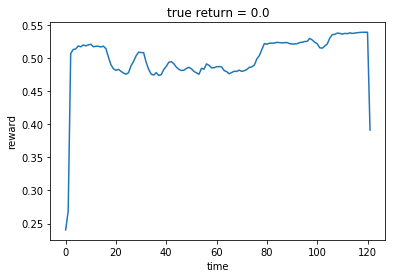

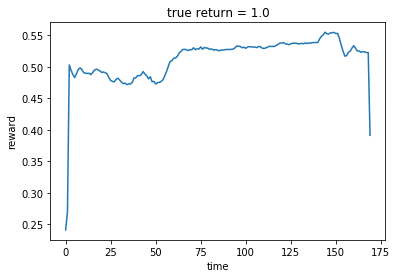

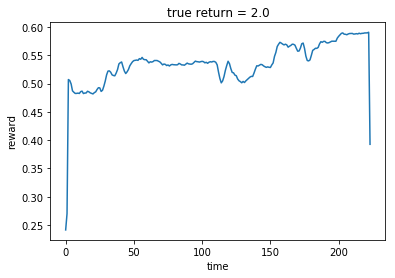

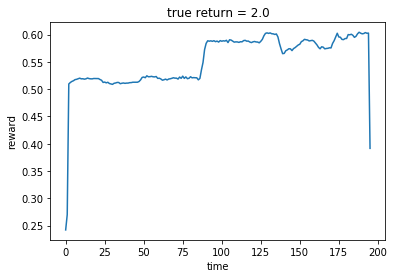

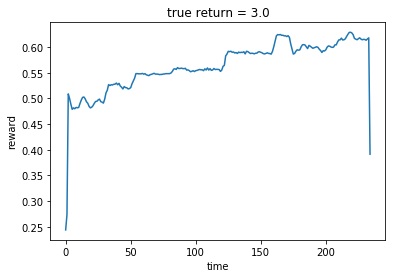

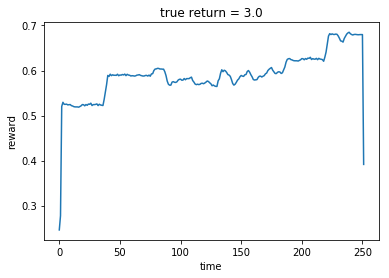

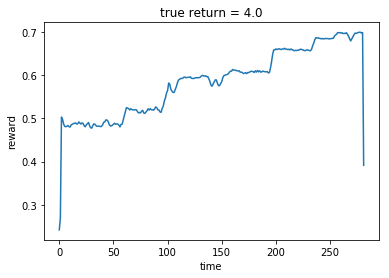

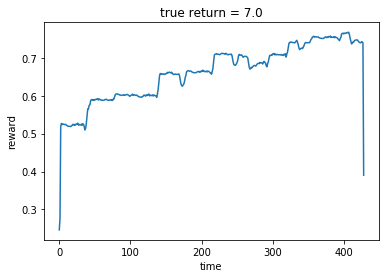

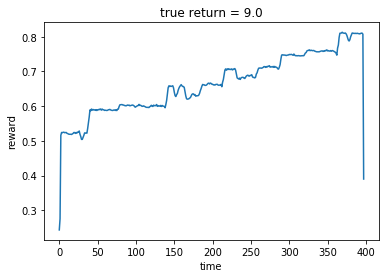

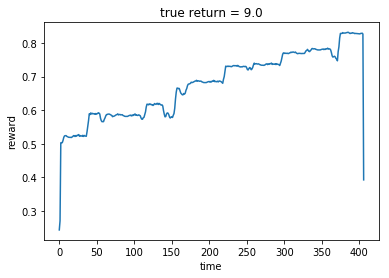

In [17]:
#print out the actual time series of rewards predicted by nnet for each trajectory.
#They are monotonically increasing, so that's good!
for d in demos_fh:
    print(len(d))

cnt = 0
with torch.no_grad():
    for d in train_demos:
        rewards = []
        print(cnt)
        for s in d:
            r = reward_fh.cum_return(torch.from_numpy(np.array([s])).float().to(device)).item()
            rewards.append(r)
        plt.figure(cnt)
        plt.plot(rewards)
        plt.xlabel("time")
        plt.ylabel("reward")
        plt.title("true return = {}".format(train_returns[cnt]))
        cnt += 1
#plt.savefig("learned_mcar_return.png")
plt.show()

Check validation accuracy

In [22]:
with torch.no_grad():
    pred_returns = [reward_fh.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in valid_demos]
for i, p in enumerate(pred_returns):
    print(i,p,valid_returns[i])

0 157.41400146484375 185.0
1 204.78366088867188 335.0
2 326.6820983886719 415.0
3 234.3553466796875 505.0
4 350.6561584472656 575.0


In [21]:
torch.save(reward.state_dict(), "./spaceinvaders_novice_reward_last40_sorted.params")